In [107]:
import numpy as np
from ppopt.mplp_program import MPLP_Program
from ppopt.mpmodel import MPModeler
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from ppopt.plot import parametric_plot
from numpy.polynomial.legendre import leggauss
from scipy.optimize import linprog
from typing import Union
from collections import defaultdict
from itertools import product

In [110]:
# Pistikopoulos and Mazzuchi (1990) Example 1
t_bounds = [(610, 630), (378, 398), (573, 593), (303, 323)]
# t_bounds = [(586.68, 653.32), (354.68, 421.32), (549.68, 616.32), (279.68, 346.32)]
nt = len(t_bounds)
nd = 0
d_bounds = None
d_vector = None
m = MPModeler()

u = m.add_var(name="u")
z = m.add_var(name="z")

t1 = m.add_param(name="t1")
t2 = m.add_param(name="t2")
t3 = m.add_param(name="t3")
t4 = m.add_param(name="t4")

m.add_constr(-z + 1.5*t2 - 525 <= u)
m.add_constr(z - 1.5*t1 - 2*t2 - 2*t3 + 2777 <= u)
m.add_constr(z - 1.5*t1 - 2*t2 - t3 + 2044 <= u)
m.add_constr(z - 1.5*t1 - 2*t2 - t3 - 2*t4 + 2830 <= u)
m.add_constr(-z + 1.5*t1 + 2*t2 + t3 + 3*t4 - 3153 <= u)
m.add_constr(t_bounds[0][0] <= t1)
m.add_constr(t1 <= t_bounds[0][1])
m.add_constr(t_bounds[1][0] <= t2)
m.add_constr(t2 <= t_bounds[1][1])
m.add_constr(t_bounds[2][0] <= t3)
m.add_constr(t3 <= t_bounds[2][1])
m.add_constr(t_bounds[3][0] <= t4)
m.add_constr(t4 <= t_bounds[3][1])
m.set_objective(u)
prob = m.formulate_problem()
prob.process_constraints()

solution_flexibility = solve_mpqp(problem=prob, algorithm=mpqp_algorithm.geometric)

def joint_pdf(theta:list):
    return (1/(5000*np.pi))*np.exp(-0.08*((theta[0]-620)**2 + (theta[1]-388)**2))

Using a found active set [0, 2]


In [112]:
for i in range(len(solution_flexibility)):
    print(f'i:{i}\nA:{solution_flexibility.critical_regions[i].A}\nb:{solution_flexibility.critical_regions[i].b}')

i:0
A:[[-0.75 -0.25 -0.5  -1.  ]
 [ 0.75  1.75  0.5   1.  ]]
b:[[ 1152.5]
 [-1677.5]]
i:1
A:[[-0.75 -0.25 -1.    0.  ]
 [ 0.75  1.75  1.    0.  ]]
b:[[ 1126.]
 [-1651.]]
i:2
A:[[2.22044605e-16 4.44089210e-16 2.22044605e-16 5.00000000e-01]
 [1.50000000e+00 2.00000000e+00 1.00000000e+00 2.50000000e+00]]
b:[[ -161.5]
 [-2991.5]]
i:3
A:[[ 1.11022302e-16  2.22044605e-16 -5.00000000e-01  1.50000000e+00]
 [ 1.50000000e+00  2.00000000e+00  1.50000000e+00  1.50000000e+00]]
b:[[ -188.]
 [-2965.]]


In [113]:
def gauss_legendre_between_bounds(expr_coeffs: np.ndarray, n_gl: int, max_idx: int = 0, min_idx: int = 1):
    """
    Generate n Gauss–Legendre quadrature points and weights between min and max bounds
    defined by two linear expressions.

    Parameters:
        expr_coeffs (np.ndarray): 2xD array. Row 0 = max point coefficients, Row 1 = min.
        n (int): Number of quadrature points.

    Returns:
        points (np.ndarray): (n, D) array of quadrature points.
        weights (np.ndarray): (n,) array of weights.
    """
    if expr_coeffs.shape[0] != 2:
        raise ValueError("expr_coeffs must have two rows")

    max_coeffs = expr_coeffs[max_idx]
    min_coeffs = expr_coeffs[min_idx]

    # Get Gauss–Legendre points and weights on [-1, 1]
    nodes, weights = leggauss(n_gl)
    weights = weights.reshape(-1,1)
    
    # Affine transformation to domain [min_coeffs, max_coeffs]
    points = 0.5 * (np.outer((nodes + 1), max_coeffs) + np.outer((1 - nodes), min_coeffs))

    # Adjust weights to match new domain
    weights = 0.5 * weights@(max_coeffs - min_coeffs).reshape(1,-1)

    return points, weights

In [114]:
def get_quadrature_points(solution, nq: int, t_vector: np.ndarray):
    # Augment t_vector once
    t_vector_aug = np.append(t_vector, 1).reshape(-1, 1)
    
    if isinstance(solution, list):
        qpoints, qweights = np.polynomial.legendre.leggauss(nq)
        min, max = solution[0], solution[1]
        qps_mapped = 0.5*(max*(1+qpoints) + min*(1-qpoints))
        qws_mapped = 0.5*(max-min)*qweights
        # print(max, min, qps_mapped, qws_mapped)
        return max, min, qps_mapped, qws_mapped
    
    for region in solution.critical_regions:
        if region.is_inside(t_vector):
            coeffs = np.concatenate([region.A, region.b], axis=1)[:2, :]
            qpoints, qweights = gauss_legendre_between_bounds(expr_coeffs=coeffs, n_gl=nq)
            return coeffs[0] @ t_vector_aug, coeffs[1] @ t_vector_aug, qpoints @ t_vector_aug, qweights @ t_vector_aug
    
    # print(f't_vector: {t_vector}')
    # print(f'solution:{solution}')
    raise ValueError("No region found that contains the given t_vector.")


In [115]:
def mpformulate_theta_bounds(flex_sol, num_theta:int, theta_bounds:list, num_design:int=0, design_bounds:list=None, psi_idx:int=0, theta_m:int=0):
    A0, b0, F0 = np.empty((len(flex_sol), num_theta)), np.empty((len(flex_sol), 1)), np.empty((len(flex_sol), num_design))
    num_cr = len(flex_sol.critical_regions)
    for i, region in enumerate(flex_sol.critical_regions):
        A0[i] = region.A[psi_idx,:num_theta]
        b0[i] = -region.b[psi_idx]
        F0[i] = -region.A[psi_idx, num_theta:num_theta+num_design]
    # print(f'num_cr:{num_cr}')
    # print(f'num_theta:{num_theta}')
    # print(f'num_design:{num_design}')
    # print(f"A0: {A0}")
    # print(f"b0: {b0}")
    # print(f"F0: {F0}")
    
    c = np.hstack([np.array([-1, 1]).reshape(1, -1), np.zeros((1, 2 * (num_theta - 1 - theta_m)))]).reshape(-1,1)
    # print(f'c:{c}')
    # print(f'c.shape: {c.shape}')
    
    row1_block = np.hstack([block for i in range(theta_m, num_theta) for block in (A0[:, [i]], np.zeros((num_cr, 1)))])
    row2_block = np.hstack([block for i in range(theta_m, num_theta) for block in (np.zeros((num_cr, 1)), A0[:, [i]])])
    bound_row = np.hstack([np.array([-1, 1]).reshape(1, -1), np.zeros((1, 2 * (num_theta - 1 - theta_m)))])
    A = np.vstack([row1_block, row2_block, bound_row, -np.eye(2*(num_theta-theta_m)), np.eye(2*(num_theta-theta_m))])
    # print(f'A: {A}')
    # print(f'A.shape: {A.shape}')
    
    x_lb = np.array([val for i in range(theta_m, len(theta_bounds)) for val in [theta_bounds[i][0]] * 2])
    x_ub = np.array([val for i in range(theta_m, len(theta_bounds)) for val in [theta_bounds[i][1]] * 2])
    b = np.vstack([b0, b0, np.zeros((1,1)), -x_lb.reshape(-1,1), x_ub.reshape(-1,1)])
    # print(f'b: {b}')
    # print(f'b.shape: {b.shape}')
    
    if F0.size==0 and theta_m==0:
        # print('here')
        return A, b, c, np.array([]), np.array([]), np.array([]), np.array([]) 
    
    F = np.vstack([F0, F0, np.zeros((1,num_design)), np.zeros((4*(num_theta-theta_m), num_design))]) if num_design>0 else np.vstack([F0, F0])
    # print(f'F:{F}')
    # print(f'F.shape: {F.shape}')
    if theta_m > 0:
        F_lltheta = np.hstack([A0[:, [i]] for i in range(theta_m)])
        # print(f'F_lltheta: {F_lltheta}')
        # print(f'F_lltheta.shape: {F_lltheta.shape}')
        F = np.hstack([np.vstack([-F_lltheta, -F_lltheta, np.zeros((1,len(range(theta_m)))), np.zeros((4*(num_theta-theta_m), theta_m))]), F]) if F.size > 0 else np.vstack([-F_lltheta, -F_lltheta, np.zeros((1,len(range(theta_m)))), np.zeros((4*(num_theta-theta_m), theta_m))])
    # print(f'F:{F}')
    # print(f'F.shape: {F.shape}')
    
    H = np.zeros((2*(num_theta-theta_m), theta_m+num_design))
    # print(f'H:{H}')
    # print(f'H.shape: {H.shape}')
    
    A_t = np.vstack([-np.eye(theta_m+num_design), np.eye(theta_m+num_design)])
    # print(f'A_t:{A_t}')
    # print(f'A_t.shape: {A_t.shape}')
    
    theta_lb = np.array([-theta_bounds[i][0] for i in range(theta_m)] + ([-j[0] for j in design_bounds] if isinstance(design_bounds, list) 
                                                                        else [])).reshape(-1, 1)
    theta_ub = np.array([theta_bounds[i][1] for i in range(theta_m)] + ([j[1] for j in design_bounds] if isinstance(design_bounds, list) 
                                                                        else [])).reshape(-1, 1)
    
    b_t = np.vstack([theta_lb, theta_ub])
    # print(f'b_t:{b_t}')
    # print(f'b_t.shape: {b_t.shape}')
    
    return A, b, c, H, A_t, b_t, F

In [116]:
def get_theta_bounds(flex_sol, numt, tbounds, numd:int=0, dbounds:list=None):
    
    theta_bound_dict = defaultdict(dict)
    prob_dict = defaultdict(dict)
    for i in range(numt):
        A, b, c, H, A_t, b_t, F = mpformulate_theta_bounds(flex_sol=flex_sol, num_theta=numt ,num_design=numd, theta_bounds=tbounds, design_bounds=dbounds, theta_m=i)
        if F.size != 0:
            # for k,j in product(range(A.shape[0]), range(A.shape[1])):
            #     if A[k][j] <= 10^(-9):
            #         A[k][j] = 0
            # if i ==2:
            #     print(f'A:{A}')
            prob = MPLP_Program(A=A, b=b, c=c, H=H, A_t=A_t, b_t=b_t, F=F)
            prob.process_constraints()
            solution = solve_mpqp(problem=prob, algorithm=mpqp_algorithm.geometric)
            prob_dict[f't{i}'] = prob
            theta_bound_dict[f't{i}'] = solution
        else:
            # print(f'A: {A}')
            # print(f'b: {b}')
            # print(f'c: {c}')
            linsol = linprog(c=c, A_ub=A, b_ub=b)
            prob_dict[f't{i}'] = linsol
            theta_bound_dict[f't{i}'] = [linsol.x[1], linsol.x[0]]
            # if linsol.success:
                # print("Optimal value:", linsol.fun)
                # print("Optimal x:", linsol.x)
        print(f'Finished solving for theta{i+1}')
    probs = [p for key, p in prob_dict.items()]
    # print([f'prob.A:{p.A}' for p in probs])
    sols = [sol for key, sol in theta_bound_dict.items()]
    
    return probs, sols
    

In [117]:
def calculate_stocflexibility(flexibility_sol, nt:int, nq: Union[int, list], theta_bounds:list, nd:int=0, d_vector: np.ndarray = None, design_bounds:list = None) -> float:
    """
    Calculates the stochastic flexibility index via nested Gauss–Legendre quadrature.

    :param sols: list of solution objects (one per stage)
    :param nq: int or list of ints; if int, used for all levels; if list, should match len(sols)
    :param d_vector: base vector used to condition quadrature
    :return: stochastic flexibility index
    """
    
    probs, sols = get_theta_bounds(flex_sol=flexibility_sol, numt=nt, numd=nd, tbounds=theta_bounds, dbounds=design_bounds)
    idx = 2
    print(f'probs[{idx}].A: {probs[idx].A}')
    print(f'probs[{idx}].b: {probs[idx].b}')
    print(f'probs[{idx}].c: {probs[idx].c}')
    print(f'probs[{idx}].H: {probs[idx].H}')
    print(f'probs[{idx}].Q_t: {probs[idx].Q_t}')
    print(f'probs[{idx}].c_t: {probs[idx].c_t}')
    print(f'probs[{idx}].c_c: {probs[idx].c_c}')
    print(f'probs[{idx}].F: {probs[idx].F}')
    print(f'probs[{idx}].At: {probs[idx].A_t}')
    print(f'probs[{idx}].bt: {probs[idx].b_t}')
    print(f'sols[{idx}: {sols[idx]}')
    # print(f'sols.type: {type(sols)}')
    # print(f'sols: {sols}')
    print(f"ncr:{len(sols[idx].critical_regions)}")
    print('finished solving all mp problems')
    parametric_plot(solution=sols[idx])
    # Validate nq if it's a list
    if isinstance(nq, list):
        if len(nq) != len(sols):
            raise ValueError("If nq is a list, it must have the same length as sols")

    def recurse(level: int, theta_prev: list, weight_prev: float) -> float:
        """
        Recursive inner function to compute nested quadrature.
        """
        # print(f'level:{level}')
        if level == len(sols):
            return weight_prev * joint_pdf(theta_prev)

        # Use nq[level] if nq is a list, otherwise use scalar nq
        nql = nq[level] if isinstance(nq, list) else nq

        t_vector = np.block([np.array(theta_prev), d_vector]) if isinstance(d_vector, np.ndarray) else np.array(theta_prev)
        # print(f't_vector:{t_vector}')
        # print(f'probs[{level}].A:{probs[level].A}')
        _, _, t_points, t_weights = get_quadrature_points(solution=sols[level], nq=nql, t_vector=t_vector)

        t_points = t_points.flatten()
        t_weights = t_weights.flatten()
        # print('t_points:', t_points)
        # print(f'theta_prev: {theta_prev}')
        return sum(recurse(level + 1, theta_prev + [v], weight_prev * w) for v, w in zip(t_points, t_weights))

    stflex =  recurse(level=0, theta_prev=[], weight_prev=1.0)
    
    return probs, sols, stflex


Finished solving for theta1
Using a found active set [10, 13, 14, 15, 17, 18]
Finished solving for theta2
Using a found active set [10, 11, 12, 13]
Finished solving for theta3
Using a found active set [2, 8]
Finished solving for theta4
probs[2].A: [[-3.65148372e-01  0.00000000e+00 -7.30296743e-01  0.00000000e+00]
 [-7.84464541e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.44089210e-16  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-3.16227766e-01  0.00000000e+00  9.48683298e-01  0.00000000e+00]
 [ 0.00000000e+00 -3.65148372e-01  0.00000000e+00 -7.30296743e-01]
 [ 0.00000000e+00 -7.84464541e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.44089210e-16  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -3.16227766e-01  0.00000000e+00  9.48683298e-01]
 [-7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -1.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+

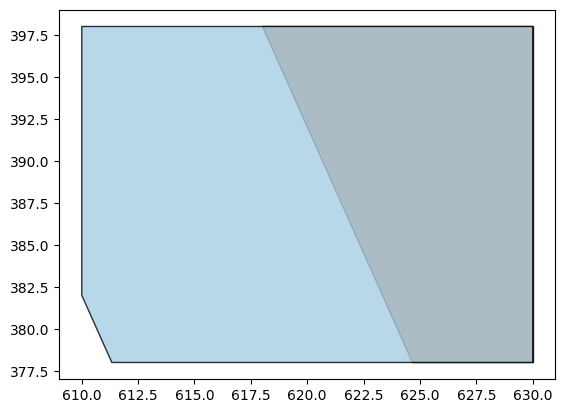

ValueError: No region found that contains the given t_vector.

In [118]:
prob_list, sol_list, sf_idx = calculate_stocflexibility(flexibility_sol=solution_flexibility, nt=nt, nq=8, theta_bounds=t_bounds, nd=nd, design_bounds=d_bounds, d_vector=d_vector)

In [ ]:
print(f'Stochastic Flexibility Index: {sf_idx:.4}')

In [ ]:
error